In [21]:
#! -*- coding: utf-8 -*-

# Ligo データアクセス　チュートリアル

このチュートリアルでは、LIGO / Virgo Open Science Center Webサイトを使用してデータを検索、ダウンロード、ロードするための基本を説明します

## O1データファイルを見つける

まず、O1データファイルを見つけようとします。

1. [ここ](https://losc.ligo.org/data) から始めます。
1. "O1 data release"で、 ["4KHz Data"](https://losc.ligo.org/archive/O1/)のアイコンをクリックします。
1. H1検出器を選択し、「続行」をクリックします。
1. 時刻1126076416で始まるH1データのURLを探します。
1. HDF5のリンクをクリックしてファイルをダウンロードします


#### 課題:

1. 時刻1126076416で始まるH1データのURLを探してHDFファイルをダウンロードしてください

# H-H1_LOSC_4_V1-1126076416-4096.hdf5

## O1データ品質セグメントリストを見つける

1. O1のデータ品質セグメントについては、https://losc.ligo.org/O1/ で読むことができます。
1. CAT 1とCAT 2のセグメントリストの違いに注目してください
1. https://losc.ligo.org/timeline/query/O1/ のタイムラインクエリフォームに移動します。
1. H1、CBC CAT 2のセグメントリストを選択します
1.セグメントリストを読むにはhttps://losc.ligo.org/segments/ こちらをご覧ください。

#### 課題:

1. CAT 1とCAT 2のセグメントリストの違いを説明する：

   cat1:原因不明なものを含む問題
   cat2:地震のように原因のわかっている問題
1. CAT 2を通過するO1、H1データの最初のセグメントはどのくらいの長さですか？


## いくつかの有用なPythonモジュールをインポートする

In [23]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys
import os

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

pyversion = sys.version_info.major
if pyversion == 2: 
    import urllib2
else:
    import urllib.request

# -- Handy function to download data file, and return the filename
def download(url):
    filename = url.split('/')[-1]
    if os.path.exists(filename):
        print('File ' + filename + " exists. Returning" )
        return filename
    print('Downloading ' + url )
    if pyversion == 2: 
        r = urllib2.urlopen(url).read()
        f = open(filename, 'w')   # write it to the right filename
        f.write(r)
        f.close()
    else:
        urllib.request.urlretrieve(url, filename)  
    print("File download complete")
    return filename

## HDF5データファイルをダウンロードする

In [24]:
# -- Use the URL for a data file you found above
url = 'https://losc.ligo.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
filename = url.split('/')[-1]
download(url)

File H-H1_LOSC_4_V1-1126076416-4096.hdf5 exists. Returning


'H-H1_LOSC_4_V1-1126076416-4096.hdf5'

## 短い時系列をプロットする

以下のコードでは：
1. `readligo.loaddata（）`メソッドを使用して、データファイルから時間ベクトルと歪みベクトルをロードします
 1. *ヒント：https://losc.ligo.org/tutorial04/* の`loaddata（）`メソッドの使い方を見てください。
1. 1000サンプルの時間の関数としてひずみをプロットする
 1. *ヒント：https://losc.ligo.org/tutorial02/* の下部にあるサンプルコード
 

File readligo.py exists. Returning


Text(0,0.5,'H1 Strain')

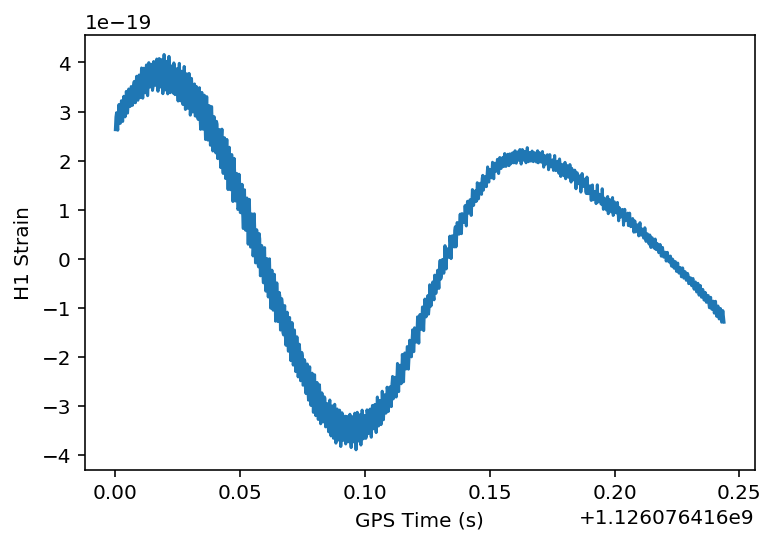

In [25]:
download('https://losc.ligo.org/s/sample_code/readligo.py')
import readligo as rl

# -- Use the loaddata() method here to load strain data
strain, time, dq = rl.loaddata(filename, 'H1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')

## PSDを作る

LIGOデータには、周波数依存性の強いノイズがあります。

1. 以下のスペースを使用して128秒のLIGOデータのPSDを作成します
 1. ヒント：例を参照してください：https://losc.ligo.org/plot_gallery/
 


Text(0.5,0,'Freq (Hz)')

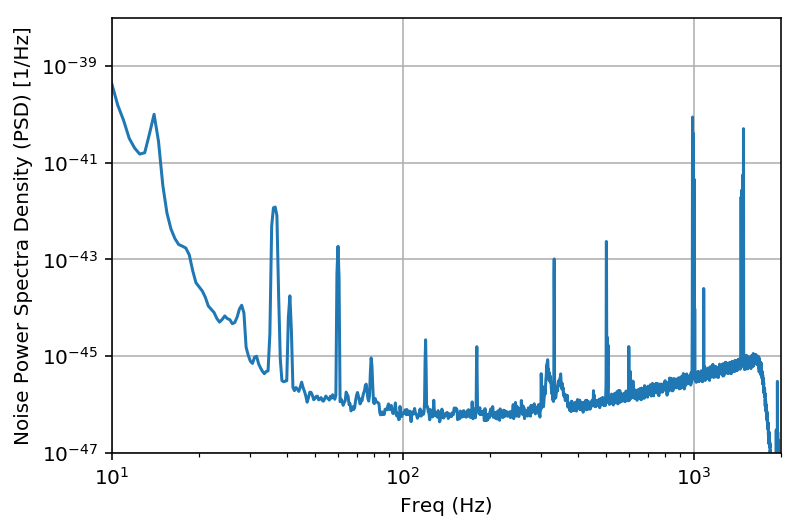

In [26]:
#-- Plot a PSD with 128 seconds of data 
ts = time[1] - time[0]      #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
length = 128                #-- Number of seconds

strain_seg = strain[0:(length*fs)]
time_seg = time[0:(length*fs)]

Pxx, freqs = mlab.psd(strain_seg, Fs=fs, NFFT=2*fs)
plt.loglog(freqs, Pxx)
plt.axis([10, 2000, 1e-47, 1e-38])
plt.grid('on')
plt.ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plt.xlabel('Freq (Hz)')

#### 課題

1. 上記のPSDの中で最も強力なラインフィーチャーは何ですか？
 1. ヒント：O1スペクトル線の注記を参照してください：https://losc.ligo.org/o1speclines/
1. LIGOにとって最も感度の高い周波数帯はどの辺りですか？
1. 20Hzでのノイズパワーと100Hzでのノイズパワーの比はどれくらいですか？
1. 低周波（f<50Hz）および高周波（f>300Hz）での主な広帯域ノイズ源は何ですか？


## GW150914を白色化（ホワイトニング）する

1. GW150914のデータを含むデータファイルをダウンロードする
 1. ヒント：GPS 1126259462.4
1. データをホワイトニングし、バンドパスする
 1. ヒント：Quickviewチュートリアルをご覧ください：https://github.com/losc-tutorial/quickview/blob/master/index.ipynb
1. 白色化して、バンドパスした時系列をプロットする。信号が見えますか？


File H-H1_LOSC_4_V2-1126259446-32.hdf5 exists. Returning


Text(0.5,1,'WHITENED strain')

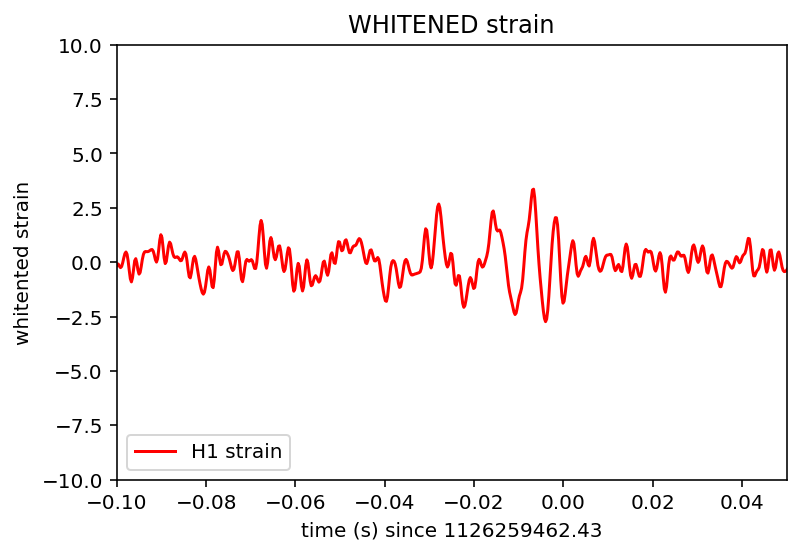

In [27]:
#-- Download a data file containing GW150914 
url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_150914 = download(url)
strain, time, chan_dict_H1 = rl.loaddata(fn_150914, 'H1')

# the time sample interval (uniformly sampled!)
t0 = 1126259462.43
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

#-- How much data to use for the ASD?
deltat = 15  # Number of seconds on each side of data
N_samp = deltat*fs

# -- Center the PSD segment on the requested time
indx = np.where(np.abs(rel_time) < dt)[0][0]
strain_seg = strain[indx-N_samp : indx+N_samp]
time_seg = rel_time[indx-N_samp : indx+N_samp]

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000

# -- Calculate PSD
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT))

# We will use interpolations of the ASDs computed above for whitening:
# in scipy.interpolate
psd = interp1d(freqs, Pxx)

# -- Whiten
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

# We need to suppress the high frequencies with some bandpassing:
high_freq = 600.
low_freq  = 30.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)

#-- Plot the whitened time series
fig2 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-0.1,0.05])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')

## もっと探求する：O1の大きなハードウェアインジェクションを見つけてプロットする

ハードウェアインジェクションは、LIGOデータに加えられた擬似信号です。

1. SNR> 40のO1、CBCハードウェアインジェクションの時刻を求める
 1. ヒント：O1のハードウェアインジェクションページを参照してください：https://losc.ligo.org/o1_inj/
1. 上でやったのように、ハードウェアインジェクションをダウンロードし、ホワイトニングし、バンドパスし、プロットする。


In [28]:
# -- Download a file containing a loud CBC hardware injection
# See https://losc.ligo.org/o1_inj/

# Whiten and band-pass data, as above
# Or, See example: https://github.com/losc-tutorial/quickview/blob/master/index.ipynb

# -- Plot the whitened time-series 